We start with first iteration

## Target:
- Reduce the model parameters by reducing the number of channels and Added depth wise convolution
- added dialated convolution for increased receptive field

## Results:
- Parameters: 97,264
- Best Training Accuracy: 72%
- Best Test Accuracy: 67%

## Analysis

- Train/test accuracy reduced after reducing the number of parameters
- still see some overfitting
  

## Import Libraries

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import torch
from torch.utils.data import DataLoader



## Check for CUDA

In [15]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if cuda else "cpu")

CUDA Available? True


## Mean and Std Deviation Computation for CIFAR-10

In [2]:
# Load CIFAR-10 without normalization
transform = transforms.ToTensor()
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=512, shuffle=True)

# Get all images in one batch
data_iter = iter(train_loader)
images, _ = next(data_iter)

# Compute mean and std across channels
mean = images.mean(dim=[0, 2, 3])
std = images.std(dim=[0, 2, 3])

print("Mean:", mean)
print("Std:", std)


100%|██████████| 170M/170M [08:50<00:00, 321kB/s] 


Mean: tensor([0.4922, 0.4759, 0.4360])
Std: tensor([0.2446, 0.2431, 0.2619])


## Load dataset

In [8]:
# Define a transform to convert PIL images to Tensors and normalize them
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4919, 0.4829, 0.4467), (0.2444, 0.2408, 0.2582))
])

# Load the training dataset, downloading it if necessary
train_data = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# Load the test dataset, downloading it if necessary
test_data = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

In [9]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

## Analyse dataset

/tmp/ipykernel_36/2980208871.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


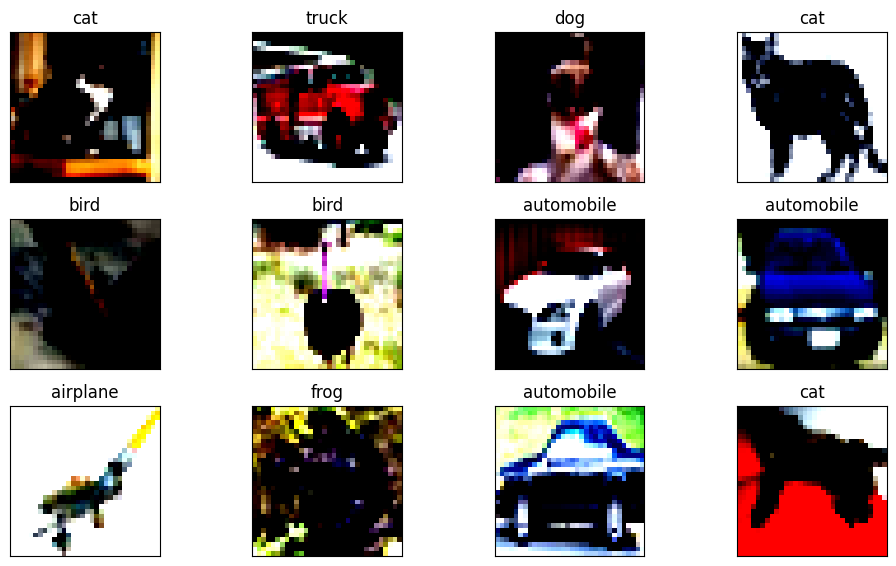

In [10]:

# Assuming batch_data is of shape [B, C, H, W] and batch_label contains class indices
fig = plt.figure(figsize=(10, 6))

# CIFAR-10 class names
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck']
batch_data, batch_label = next(iter(train_loader))


for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.tight_layout()
    plt.imshow(batch_data[i].permute(1, 2, 0))  # Convert from [C, H, W] to [H, W, C]
    plt.title(classes[batch_label[i]])
    plt.xticks([])
    plt.yticks([])

plt.show()

## Model Architecture 

In [23]:
import torch.nn as nn
import torch.nn.functional as F


class CIFAR10(nn.Module):
    def __init__(self):
        super(CIFAR10, self).__init__()
        self.drop_prob = 0.01
        ## Convolution Block1
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1, bias = False),  # Input: 32x32x3 | Output: 32x32x32 | RF: 3x3
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(self.drop_prob),

            nn.Conv2d(32, 64, 3, padding=1, bias = False), # Input: 32x32x32 | Output: 32x32x64 | RF: 5x5
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(self.drop_prob)
        )
        
        ## Transition Block1
        self.trans1 = nn.Sequential(
            nn.Conv2d(64, 32,1, stride=2), # Input: 32x32x64 | Output: 16x16x32 | RF: 5x5
            nn.ReLU(),
        )

        ## Convolution Block2
        self.conv2 =  nn.Sequential(
            nn.Conv2d(32, 32, 3,  padding=1, bias = False), # Input: 16x16x32 | Output: 16x16x32 | RF: 9x9
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(self.drop_prob),

            ## Depthwise Seperable Convolution1
            nn.Conv2d(32,32, 3,  padding=1,groups=32 ,bias = False),  # Input: 16x16x32 | Output: 16x16x32 | RF: 13x13
            nn.Conv2d(32, 64, 1, padding=1, bias = False),   # Input: 16x16x32 | Output: 18x18x64 | RF: 13x13
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(self.drop_prob),
        )
        
        #Transition Block2
        self.trans2 = nn.Sequential(

            nn.Conv2d(64, 32, 1, stride=2), # Input: 18x18x32 | Output: 9x9x64 | RF: 13x13
            nn.ReLU()
        )

        #Convolution Block3
        self.conv3 = nn.Sequential(
            
            ## Dilation Block
            nn.Conv2d(32, 64, 3,  padding=1, bias = False,dilation=2), # Input: 9x9x64 | Output: 7x7x64 | RF: 29x29
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(self.drop_prob),

            nn.Conv2d(64, 64, 3,  padding=1, bias = False),  # Input: 7x7x64| Output: 7x7x64 | RF: 45x45
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(self.drop_prob),
        )

        #Transition Block3
        self.trans3 = nn.Sequential(

            nn.Conv2d(64, 16, 1, stride=2), # Input: 7x7x64| Output: 4x4x16 | RF: 61x61
            nn.ReLU()
        )

        #Convolution Block4        
        self.conv4 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1, bias = False), # Input: 4x4x16 | Output: 4x4x32 | RF: 93x93
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(self.drop_prob),

            ## Depthwise seperable Convolution2
            nn.Conv2d(32,32, 3,  padding=1,groups=32 ,bias = False),# Input: 4x4x16 | Output: 4x4x32 | RF: 125x125
            nn.Conv2d(32, 10, 1, padding=1, bias = False),          # Input: 4x4x32| Output: 6x6x10 | RF: 125x125
            nn.ReLU(),
            # nn.BatchNorm2d(10),
        )

        ## Output Block
        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool2d(1)
        ) 


    def forward(self, x):
        x = self.conv1(x)
        x = self.trans1(x)

        x = self.conv2(x) 
        x = self.trans2(x) 

        x = self.conv3(x) 
        x = self.trans3(x)

        x = self.conv4(x)
        x = self.gap(x)

        x = x.view(-1,10)
        return F.log_softmax(x,dim=1)

In [24]:
model = CIFAR10().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
         Dropout2d-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
         Dropout2d-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 32, 16, 16]           2,080
             ReLU-10           [-1, 32, 16, 16]               0
           Conv2d-11           [-1, 32, 16, 16]           9,216
             ReLU-12           [-1, 32, 16, 16]               0
      BatchNorm2d-13           [-1, 32, 16, 16]              64
        Dropout2d-14           [-1, 32,

In [25]:
print(model)

CIFAR10(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout2d(p=0.01, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout2d(p=0.01, inplace=False)
  )
  (trans1): Sequential(
    (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(2, 2))
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout2d(p=0.01, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (5): Conv2d(32, 64, kernel_size=(1,

## Train and test Loop

In [27]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    loss = 0
    correct = 0
    processed = 0
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        pbar.set_description(desc= f'Train loss={loss.item():0.4f} batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
    train_losses.append(loss/len(train_loader))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

## Model Training

In [28]:
model = CIFAR10CustomNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15, eta_min=0.0005)

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
num_epochs = 30

for epoch in range(1, num_epochs+1):
    print(f'Epoch {epoch}')
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

Epoch 1


Train loss=1.8817 batch_id=97 Accuracy=21.02: 100%|██████████| 98/98 [00:06<00:00, 15.19it/s]


Test set: Average loss: 1.8485, Accuracy: 2876/10000 (28.76%)

Epoch 2


Train loss=1.7164 batch_id=97 Accuracy=33.25: 100%|██████████| 98/98 [00:06<00:00, 15.55it/s]


Test set: Average loss: 1.6606, Accuracy: 3757/10000 (37.57%)

Epoch 3


Train loss=1.4201 batch_id=97 Accuracy=40.11: 100%|██████████| 98/98 [00:06<00:00, 15.00it/s]


Test set: Average loss: 1.5073, Accuracy: 4349/10000 (43.49%)

Epoch 4


Train loss=1.4251 batch_id=97 Accuracy=45.14: 100%|██████████| 98/98 [00:06<00:00, 15.18it/s]


Test set: Average loss: 1.3968, Accuracy: 4788/10000 (47.88%)

Epoch 5


Train loss=1.2939 batch_id=97 Accuracy=49.63: 100%|██████████| 98/98 [00:06<00:00, 15.02it/s]


Test set: Average loss: 1.3198, Accuracy: 5122/10000 (51.22%)

Epoch 6


Train loss=1.3225 batch_id=97 Accuracy=53.02: 100%|██████████| 98/98 [00:06<00:00, 15.33it/s]


Test set: Average loss: 1.2718, Accuracy: 5314/10000 (53.14%)

Epoch 7


Train loss=1.1446 batch_id=97 Accuracy=55.80: 100%|██████████| 98/98 [00:06<00:00, 15.23it/s]


Test set: Average loss: 1.2092, Accuracy: 5553/10000 (55.53%)

Epoch 8


Train loss=1.2239 batch_id=97 Accuracy=58.08: 100%|██████████| 98/98 [00:06<00:00, 15.36it/s]


Test set: Average loss: 1.1817, Accuracy: 5709/10000 (57.09%)

Epoch 9


Train loss=1.0430 batch_id=97 Accuracy=60.01: 100%|██████████| 98/98 [00:06<00:00, 15.41it/s]


Test set: Average loss: 1.1222, Accuracy: 5908/10000 (59.08%)

Epoch 10


Train loss=0.9980 batch_id=97 Accuracy=61.64: 100%|██████████| 98/98 [00:06<00:00, 15.53it/s]


Test set: Average loss: 1.1017, Accuracy: 6042/10000 (60.42%)

Epoch 11


Train loss=0.9468 batch_id=97 Accuracy=63.33: 100%|██████████| 98/98 [00:06<00:00, 15.15it/s]


Test set: Average loss: 1.0676, Accuracy: 6144/10000 (61.44%)

Epoch 12


Train loss=1.0481 batch_id=97 Accuracy=64.78: 100%|██████████| 98/98 [00:06<00:00, 15.15it/s]


Test set: Average loss: 1.0277, Accuracy: 6349/10000 (63.49%)

Epoch 13


Train loss=1.0594 batch_id=97 Accuracy=65.85: 100%|██████████| 98/98 [00:06<00:00, 15.33it/s]


Test set: Average loss: 1.0225, Accuracy: 6310/10000 (63.10%)

Epoch 14


Train loss=0.9372 batch_id=97 Accuracy=67.07: 100%|██████████| 98/98 [00:06<00:00, 15.22it/s]


Test set: Average loss: 1.0188, Accuracy: 6343/10000 (63.43%)

Epoch 15


Train loss=0.9881 batch_id=97 Accuracy=68.01: 100%|██████████| 98/98 [00:06<00:00, 14.89it/s]


Test set: Average loss: 0.9836, Accuracy: 6528/10000 (65.28%)

Epoch 16


Train loss=0.7507 batch_id=97 Accuracy=70.48: 100%|██████████| 98/98 [00:06<00:00, 15.26it/s]


Test set: Average loss: 0.9405, Accuracy: 6636/10000 (66.36%)

Epoch 17


Train loss=0.7781 batch_id=97 Accuracy=70.76: 100%|██████████| 98/98 [00:06<00:00, 14.76it/s]


Test set: Average loss: 0.9336, Accuracy: 6677/10000 (66.77%)

Epoch 18


Train loss=0.7510 batch_id=97 Accuracy=71.37: 100%|██████████| 98/98 [00:06<00:00, 15.36it/s]


Test set: Average loss: 0.9344, Accuracy: 6668/10000 (66.68%)

Epoch 19


Train loss=0.7960 batch_id=97 Accuracy=71.28: 100%|██████████| 98/98 [00:06<00:00, 15.28it/s]


Test set: Average loss: 0.9307, Accuracy: 6678/10000 (66.78%)

Epoch 20


Train loss=0.8055 batch_id=97 Accuracy=71.72: 100%|██████████| 98/98 [00:06<00:00, 15.35it/s]


Test set: Average loss: 0.9323, Accuracy: 6685/10000 (66.85%)

Epoch 21


Train loss=0.8451 batch_id=97 Accuracy=71.67: 100%|██████████| 98/98 [00:06<00:00, 15.01it/s]


Test set: Average loss: 0.9278, Accuracy: 6712/10000 (67.12%)

Epoch 22


Train loss=0.7906 batch_id=97 Accuracy=71.90: 100%|██████████| 98/98 [00:06<00:00, 15.29it/s]


Test set: Average loss: 0.9300, Accuracy: 6698/10000 (66.98%)

Epoch 23


Train loss=0.7944 batch_id=97 Accuracy=71.96: 100%|██████████| 98/98 [00:06<00:00, 15.25it/s]


Test set: Average loss: 0.9242, Accuracy: 6728/10000 (67.28%)

Epoch 24


Train loss=0.7475 batch_id=97 Accuracy=72.15: 100%|██████████| 98/98 [00:06<00:00, 15.16it/s]


Test set: Average loss: 0.9272, Accuracy: 6740/10000 (67.40%)

Epoch 25


Train loss=0.8406 batch_id=97 Accuracy=72.27: 100%|██████████| 98/98 [00:06<00:00, 15.13it/s]


Test set: Average loss: 0.9239, Accuracy: 6726/10000 (67.26%)

Epoch 26


Train loss=0.7986 batch_id=97 Accuracy=72.51: 100%|██████████| 98/98 [00:06<00:00, 15.08it/s]


Test set: Average loss: 0.9217, Accuracy: 6736/10000 (67.36%)

Epoch 27


Train loss=0.6779 batch_id=97 Accuracy=72.80: 100%|██████████| 98/98 [00:06<00:00, 15.20it/s]


Test set: Average loss: 0.9267, Accuracy: 6712/10000 (67.12%)

Epoch 28


Train loss=0.7894 batch_id=97 Accuracy=72.64: 100%|██████████| 98/98 [00:06<00:00, 15.24it/s]


Test set: Average loss: 0.9253, Accuracy: 6726/10000 (67.26%)

Epoch 29


Train loss=0.7338 batch_id=97 Accuracy=72.71: 100%|██████████| 98/98 [00:06<00:00, 15.37it/s]


Test set: Average loss: 0.9260, Accuracy: 6746/10000 (67.46%)

Epoch 30


Train loss=0.8196 batch_id=97 Accuracy=72.65: 100%|██████████| 98/98 [00:06<00:00, 15.13it/s]


Test set: Average loss: 0.9184, Accuracy: 6732/10000 (67.32%)



## Misclassifications

In [29]:
import matplotlib.pyplot as plt

def get_misclassified(model, loader, device):
    model.eval()
    misclassified = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)

            # compare predicted vs actual
            wrong_idx = pred.squeeze().ne(target).nonzero(as_tuple=True)[0]

            for idx in wrong_idx:
                misclassified.append((data[idx].cpu(), pred[idx].item(), target[idx].item()))
    return misclassified

In [30]:
def plot_misclassified(misclassified, n=25):
    plt.figure(figsize=(10,10))
    for i, (img, pred, true) in enumerate(misclassified[:n]):
        plt.subplot(5,5,i+1)
        plt.imshow(img.permute(1, 2, 0), cmap="gray")
        plt.title(f"P:{classes[pred]}, T:{classes[true]}")
        plt.axis("off")
    plt.show()


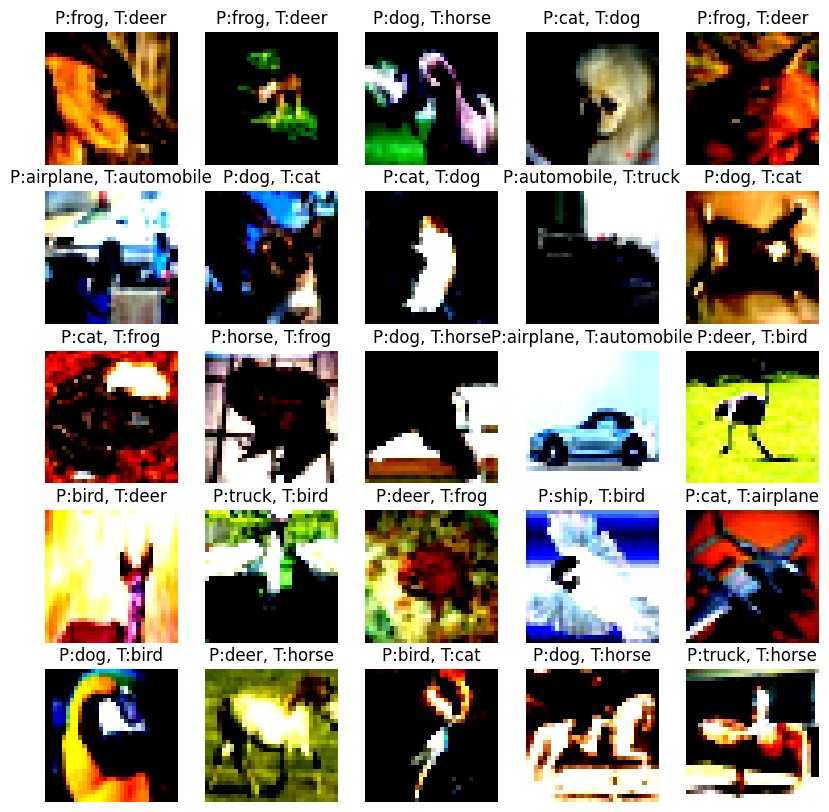

In [31]:
misclassified = get_misclassified(model, test_loader, device)
plot_misclassified(misclassified, n=25)

## Train and Test Loss

Text(0.5, 1.0, 'Test Accuracy')

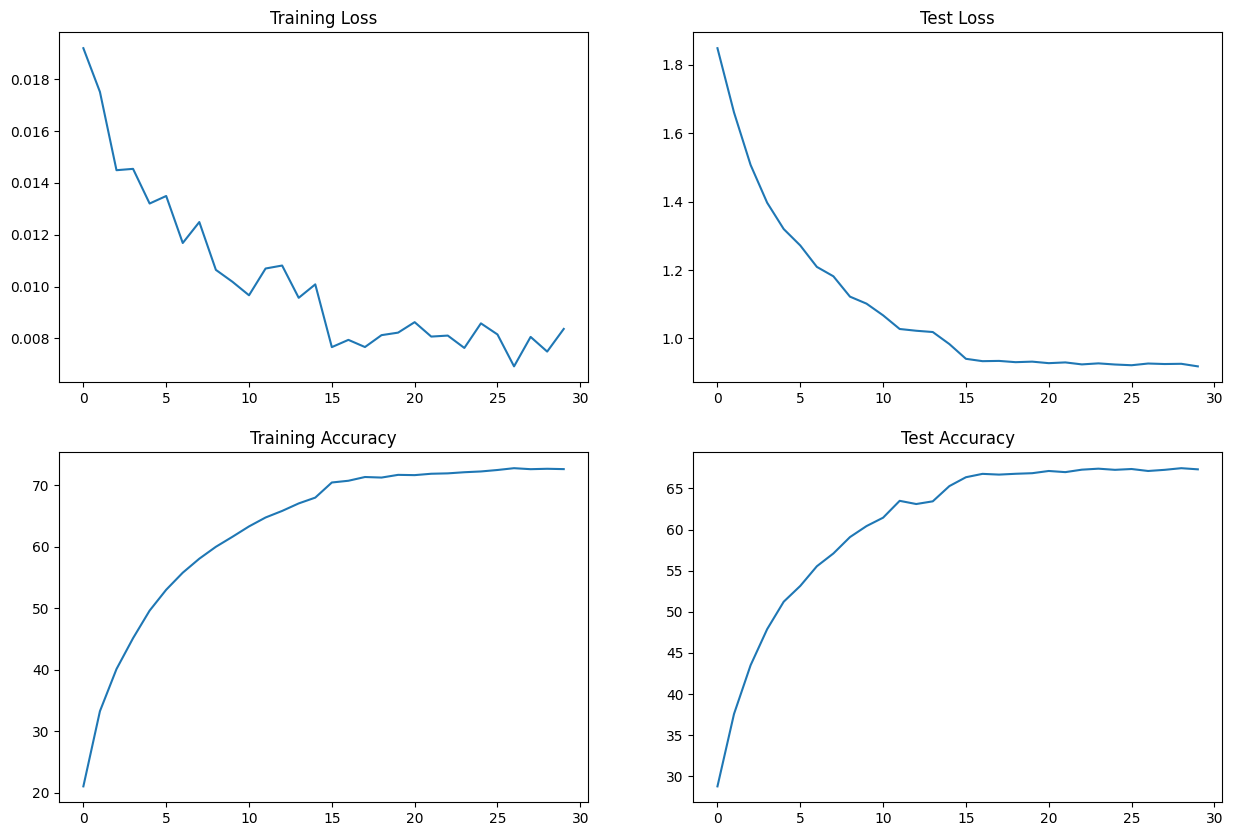

In [32]:
t = [t_items.item() for t_items in train_losses]
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")